In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score

In [ ]:
loaded_data = np.load("embeddings/hyb_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

In [6]:
df = pd.read_csv('labels.csv')

In [7]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])

test_labels = pd.read_csv('test_pairs.csv')

print(" ")

ast_pairs_test = []
labels_test = []

for _,row in test_labels.iterrows():
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_test.append((ast1,ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_test.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [8]:
class CodePlagiarismDataset(Dataset):
    def __init__(self,embed,lab):
        self.embeddings1 = np.array([e[0] for e in embed])  # Convert string to array
        self.embeddings2 = np.array([e[1] for e in embed])
        self.labels = np.array(lab).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb1 = torch.tensor(self.embeddings1[idx], dtype=torch.float32)
        emb2 = torch.tensor(self.embeddings2[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return emb1, emb2, label  

In [9]:
class SiamesePlagiarismClassifier(nn.Module):
    def __init__(self, input_size=1024):  # Updated input size
        super(SiamesePlagiarismClassifier, self).__init__()

        self.shared_fc = nn.Sequential(
            nn.Linear(input_size, 512),  # Reduce from 896 to 512
            nn.BatchNorm1d(512),  # Batch Normalization for stability
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        
        )

        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        emb1 = self.shared_fc(emb1)
        emb2 = self.shared_fc(emb2)
        similarity = torch.abs(emb1 - emb2)
        return self.sigmoid(self.out(similarity))

In [10]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
train_dataset = CodePlagiarismDataset(ast_pairs_test,labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
model = SiamesePlagiarismClassifier(input_size = 1024).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for emb1, emb2, labels in train_loader:
        emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(emb1, emb2).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")



Epoch [1/100], Loss: 0.5839
Epoch [2/100], Loss: 0.5190
Epoch [3/100], Loss: 0.4649
Epoch [4/100], Loss: 0.4284
Epoch [5/100], Loss: 0.3723
Epoch [6/100], Loss: 0.3802
Epoch [7/100], Loss: 0.3319
Epoch [8/100], Loss: 0.3052
Epoch [9/100], Loss: 0.2891
Epoch [10/100], Loss: 0.3098
Epoch [11/100], Loss: 0.2362
Epoch [12/100], Loss: 0.2322
Epoch [13/100], Loss: 0.2041
Epoch [14/100], Loss: 0.2047
Epoch [15/100], Loss: 0.1572
Epoch [16/100], Loss: 0.1695
Epoch [17/100], Loss: 0.2773
Epoch [18/100], Loss: 0.2305
Epoch [19/100], Loss: 0.1998
Epoch [20/100], Loss: 0.1672
Epoch [21/100], Loss: 0.1539
Epoch [22/100], Loss: 0.1214
Epoch [23/100], Loss: 0.1263
Epoch [24/100], Loss: 0.1457
Epoch [25/100], Loss: 0.1656
Epoch [26/100], Loss: 0.1028
Epoch [27/100], Loss: 0.0914
Epoch [28/100], Loss: 0.0996
Epoch [29/100], Loss: 0.0963
Epoch [30/100], Loss: 0.1058
Epoch [31/100], Loss: 0.0814
Epoch [32/100], Loss: 0.1329
Epoch [33/100], Loss: 0.0985
Epoch [34/100], Loss: 0.0957
Epoch [35/100], Loss: 0

In [ ]:
torch.save(model.state_dict(), 'models/100_bert.pth')

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Plagiarized", "Plagiarized"],
                yticklabels=["Non-Plagiarized", "Plagiarized"])
    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 0.8377
Precision: 0.6951
Recall: 0.8261
F1-Score: 0.7550
F1.5-Score: 0.7808


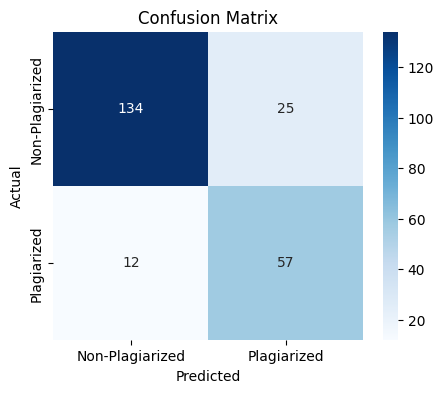

In [17]:
model.eval()

#val_model = SiamesePlagiarismClassifier().to(device)
#val_model.load_state_dict(torch.load('50_hyb.pth', map_location=device))

#val_model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for emb1, emb2, labels in test_loader:
        emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
        outputs = model(emb1, emb2).squeeze()
        predictions = (outputs > 0.412).float() 

        all_labels.extend(labels.cpu().numpy()) 
        all_predictions.extend(predictions.cpu().numpy())

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
f15 = fbeta_score(all_labels, all_predictions, beta=1.5)


print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F1.5-Score: {f15:.4f}")

plot_confusion_matrix(all_labels, all_predictions)